# Science Radar
Aplicación para la detección automática de frentes de investigación.

In [2]:
%colors lightbg
%matplotlib inline
import pandas
from commands.network_generation import *
from commands.network_analysis import *
from commands.europe_pmc_harvester import *
from commands.burst_detection import *
from utils.fulltext_downloader import download_fulltext
from utils.bioportal_api import annotate_text
from utils import mongodb_access
from joblib import delayed, Parallel
import logging
import click_log
import matplotlib.pyplot as plt

/usr/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Recolección de datos

### Parámetros para la recolección de datos

In [3]:
dataset_name = 'necroptosis'
keywords = ['Neutrophil and necroptosis']
pmids = []
include_citing_papers = True
output_path = 'data/sciradar'
start_year = 2010
end_year = 2018
mongo_config = {
    'database': 'publications',
    'collection': 'necroptosis',
    'host': 'mongodb',
    'port': 27017
}

### Creación de directorio de salida

In [4]:
output_path = output_path + '/' if not output_path.endswith('/') else output_path
output_path += dataset_name + '/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

### Recolección de datos desde [EuropePMC](https://europepmc.org/)

In [4]:
click.secho("Harvesting papers", fg='yellow')
references = harvest_papers_metadata(keywords, pmids, start_year, end_year, include_citing_papers=include_citing_papers)

Harvesting papers
Harvest for "Neutrophil and necroptosis"
       Harvested 304 of 304
       Harvested 304 of 304
Getting references for 304 "Neutrophil and necroptosis" papers



Harvesting citations for 304 papers


In [5]:
def get_paper_fulltext(reference, output_path):
    if os.path.isfile(output_path + 'json/' + reference['id'] + '.json'):
        with open(output_path + 'json/' + reference['id'] + '.json') as f:
            reference = json.load(f)
        return reference
    reference['fullText'] = download_fulltext(reference, output_path)
    return reference


def annotate_reference(reference, output_path):
    if os.path.isfile(output_path + 'json/' + reference['id'] + '.json'):
        with open(output_path + 'json/' + reference['id'] + '.json') as f:
            reference = json.load(f)
        return reference
    if reference['fullText'].strip() is not '':
        reference['annotations'] = annotate_text(reference['fullText'].strip())
    else:
        text = reference['title']
        text += reference['abstractText'] if 'abstractText' in reference else ''
        reference['annotations'] = annotate_text(text)
    with open(output_path + 'json/' + reference['id'] + '.json', 'w') as fp:
        json.dump(reference, fp, default=default, indent=4, sort_keys=True)


def default(o):
    if type(o) is datetime.date or type(o) is datetime.datetime:
        return o.isoformat()

In [6]:
    click.secho("Getting fulltext", fg='yellow')
    references = Parallel(n_jobs=25)(delayed(get_paper_fulltext)(reference, output_path) for reference in tqdm(references))

Getting fulltext


In [5]:
if not os.path.exists(output_path + 'json/'):
    os.makedirs(output_path + 'json/')

In [ ]:
click.secho("Annotating papers", fg='yellow')
Parallel(n_jobs=25)(delayed(annotate_reference)(reference, output_path) for reference in tqdm(references))

Annotating papers


In [6]:
mongodb_access.save_directory(output_path + 'json/', 'publications', dataset_name, 'mongodb')

## Análisis de redes

In [7]:
if not os.path.exists(output_path + 'gt/'):
    os.makedirs(output_path + 'gt/')

### Generación Red de Co-autoría

In [16]:
coauthorship_networks = generate_co_authorship_networks_incremental('', 'necroptosis', 2010, 2019, output_path=output_path + 'gt/',
                                            mongo_config=mongo_config, save=True, use_cache=True)

   Generating network for range 2010-1 to 2010-1
   Generating network for range 2010-1 to 2010-2
   Generating network for range 2010-1 to 2010-3
   Generating network for range 2010-1 to 2010-4
   Generating network for range 2010-1 to 2010-5
   Generating network for range 2010-1 to 2010-6
   Generating network for range 2010-1 to 2010-7
   Generating network for range 2010-1 to 2010-8
   Generating network for range 2010-1 to 2010-9
   Generating network for range 2010-1 to 2010-10
   Generating network for range 2010-1 to 2010-11
   Generating network for range 2010-1 to 2010-12
   Generating network for range 2010-1 to 2011-1
   Generating network for range 2010-1 to 2011-2
   Generating network for range 2010-1 to 2011-3
   Generating network for range 2010-1 to 2011-4
   Generating network for range 2010-1 to 2011-5
   Generating network for range 2010-1 to 2011-6
   Generating network for range 2010-1 to 2011-7
   Generating network for range 2010-1 to 2011-8
   Generating net

In [17]:
coauthorship_analysis = analyse_networks(coauthorship_networks, output_path + 'gt/co-authorship-json')

       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2010-9 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2010-10 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2010-11 network
       Getting degree histogram
      

       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2012-10 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2012-11 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2012-12 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient

       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2014-12 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2015-1 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2015-2 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Ge

   Analysing 2010-1 to 2017-1 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2017-2 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2017-3 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2017-4 network
  

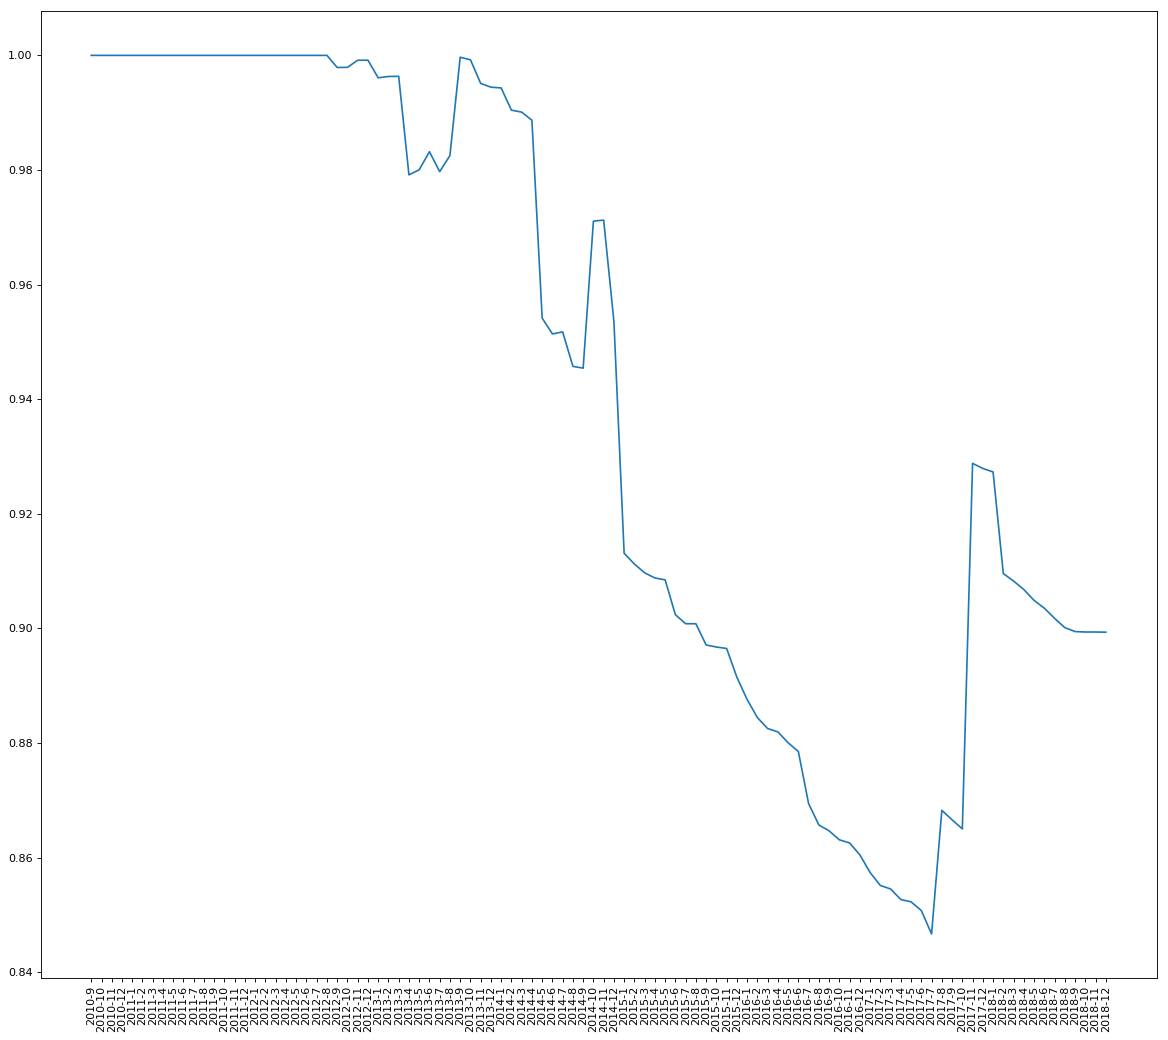

In [18]:
dates = coauthorship_analysis.keys()
values = [analysis['clustering_coefficient'][0] for analysis in coauthorship_analysis.values()]
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates, values)
plt.xticks(list(dates), [date.split(' to ')[1] for date in dates], rotation='vertical')
plt.show()

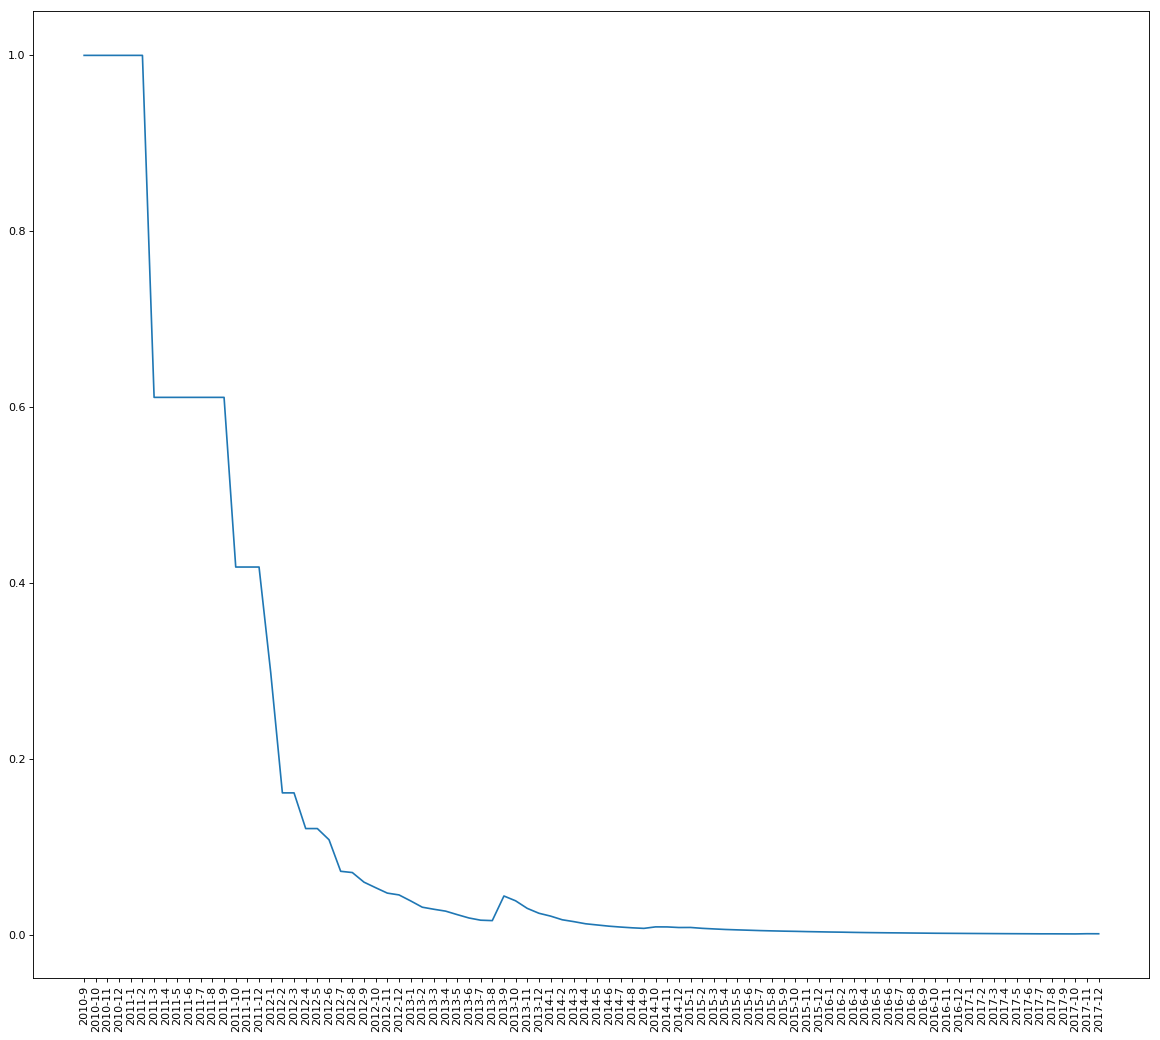

In [14]:
dates = coauthorship_analysis.keys()
values = [analysis['density'] for analysis in coauthorship_analysis.values()]
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates, values)
plt.xticks(list(dates), [date.split(' to ')[1] for date in dates], rotation='vertical')
plt.show()

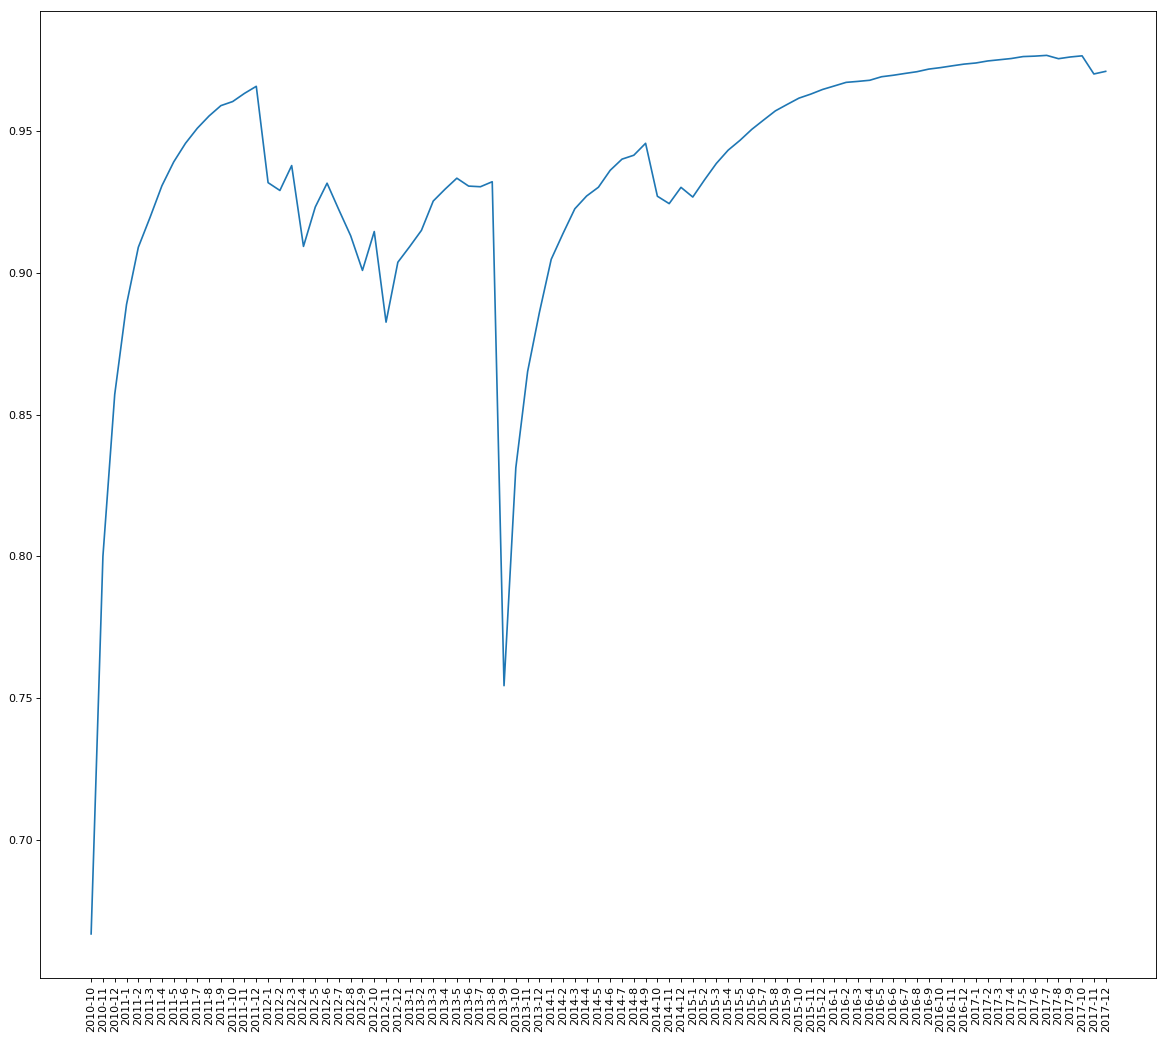

In [15]:
dates = list(coauthorship_analysis.keys())[1:]
values = [analysis['similarity_year_before'] for analysis in list(coauthorship_analysis.values())[1:]]
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates, values)
plt.xticks(list(dates), [date.split(' to ')[1] for date in dates], rotation='vertical')
plt.show()

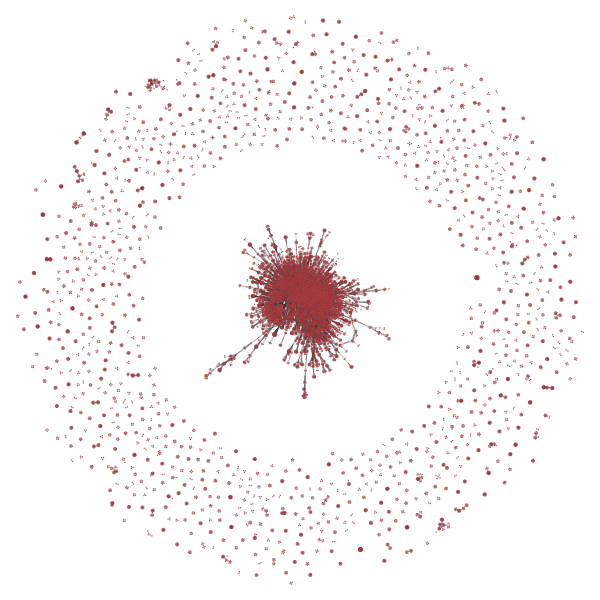

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f0d4dc17f98, at 0x7f0d2ff93a90>

In [29]:
graph_draw(coauthorship_networks['2010-1 to 2017-12'])

### Generación Red de Co-citación

In [7]:
co_citation_networks = get_co_citation_network_incremental('', 'zika', 2010, 2018, output_path=output_path + 'gt/',
                                            mongo_config=mongo_config, save=True, use_cache=True)

   Generating network for range 2010-1 to 2010-1
   Generating network for range 2010-1 to 2010-2
   Generating network for range 2010-1 to 2010-3
   Generating network for range 2010-1 to 2010-4
   Generating network for range 2010-1 to 2010-5
   Generating network for range 2010-1 to 2010-6
   Generating network for range 2010-1 to 2010-7
   Generating network for range 2010-1 to 2010-8
   Generating network for range 2010-1 to 2010-9
   Generating network for range 2010-1 to 2010-10
   Generating network for range 2010-1 to 2010-11
   Generating network for range 2010-1 to 2010-12
   Generating network for range 2010-1 to 2011-1
   Generating network for range 2010-1 to 2011-2
   Generating network for range 2010-1 to 2011-3
   Generating network for range 2010-1 to 2011-4
   Generating network for range 2010-1 to 2011-5
   Generating network for range 2010-1 to 2011-6
   Generating network for range 2010-1 to 2011-7
   Generating network for range 2010-1 to 2011-8
   Generating net

In [8]:
co_citation_analysis = analyse_networks(co_citation_networks, output_path + 'gt/co-citation.json')

       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2010-7 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2010-8 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2010-9 network
       Getting degree histogram
       G

       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2012-8 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2012-9 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2012-10 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
 

       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2014-10 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2014-11 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2014-12 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       

   Analysing 2010-1 to 2016-11 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2016-12 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2017-1 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2017-2 network


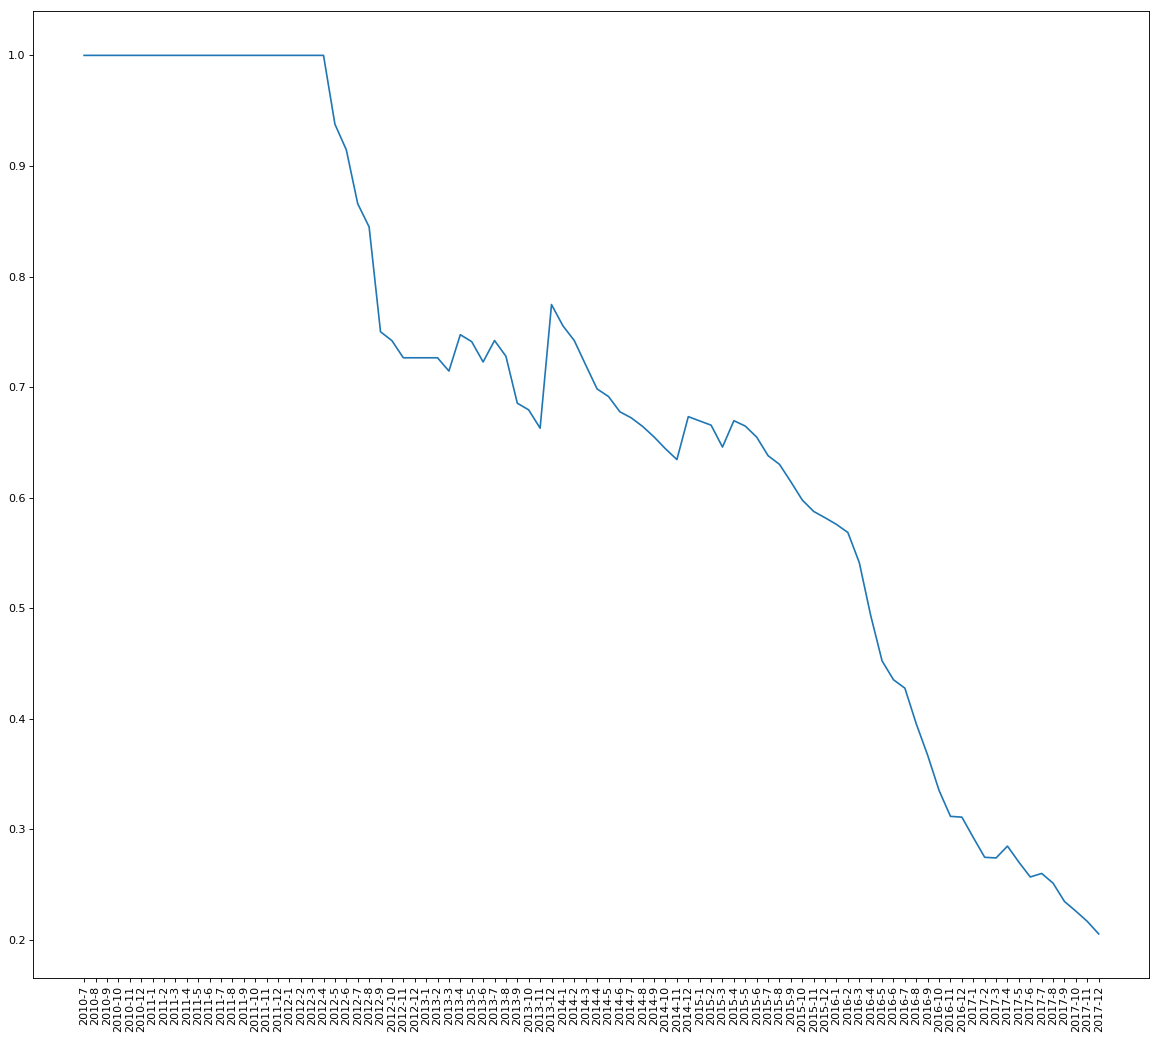

In [21]:
dates = co_citation_analysis.keys()
values = [analysis['clustering_coefficient'][0] for analysis in co_citation_analysis.values()]
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates, values)
plt.xticks(list(dates), [date.split(' to ')[1] for date in dates], rotation='vertical')
plt.show()

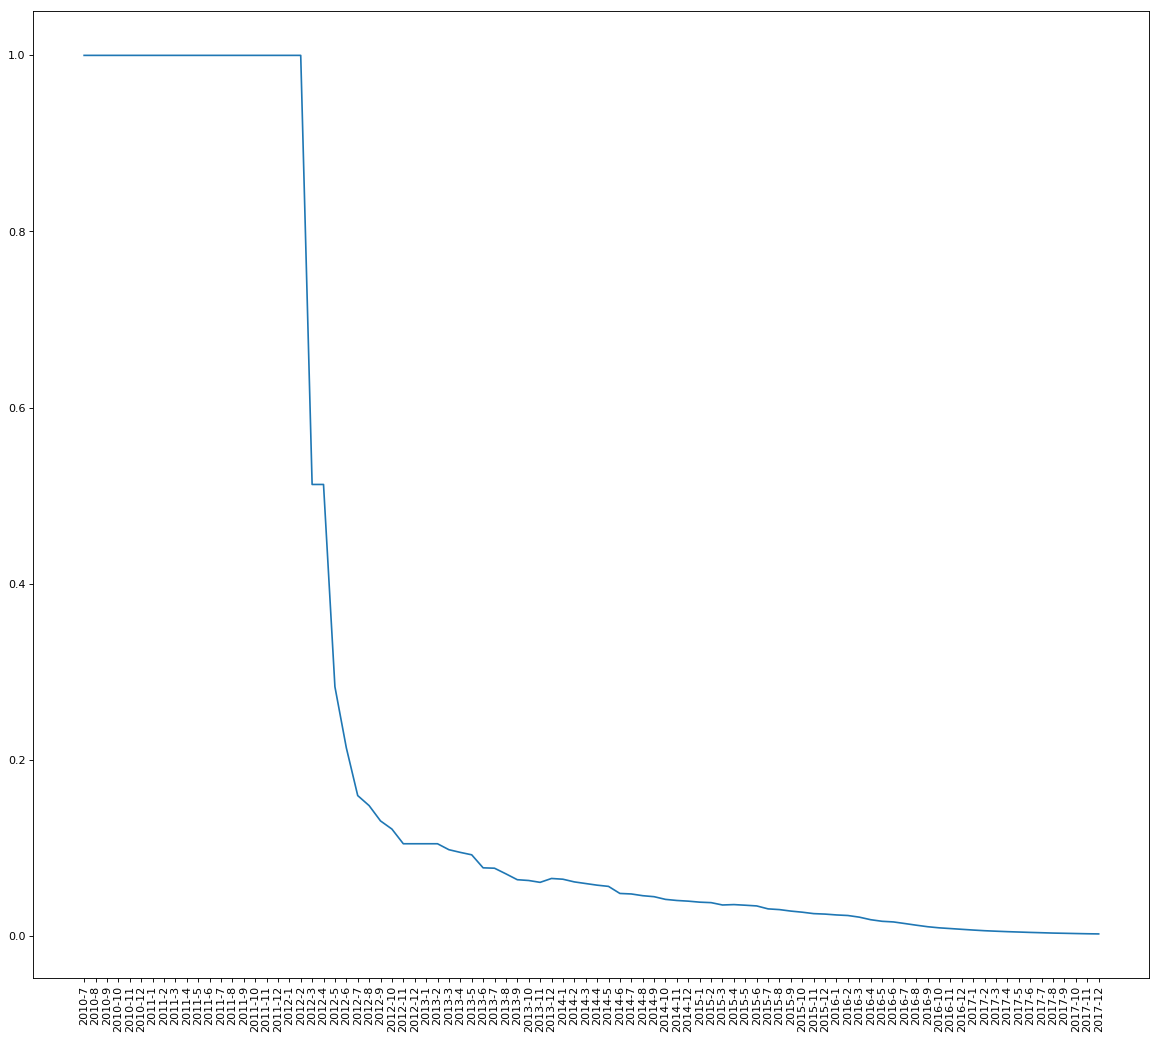

In [23]:
dates = co_citation_analysis.keys()
values = [analysis['density'] for analysis in co_citation_analysis.values()]
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates, values)
plt.xticks(list(dates), [date.split(' to ')[1] for date in dates], rotation='vertical')
plt.show()

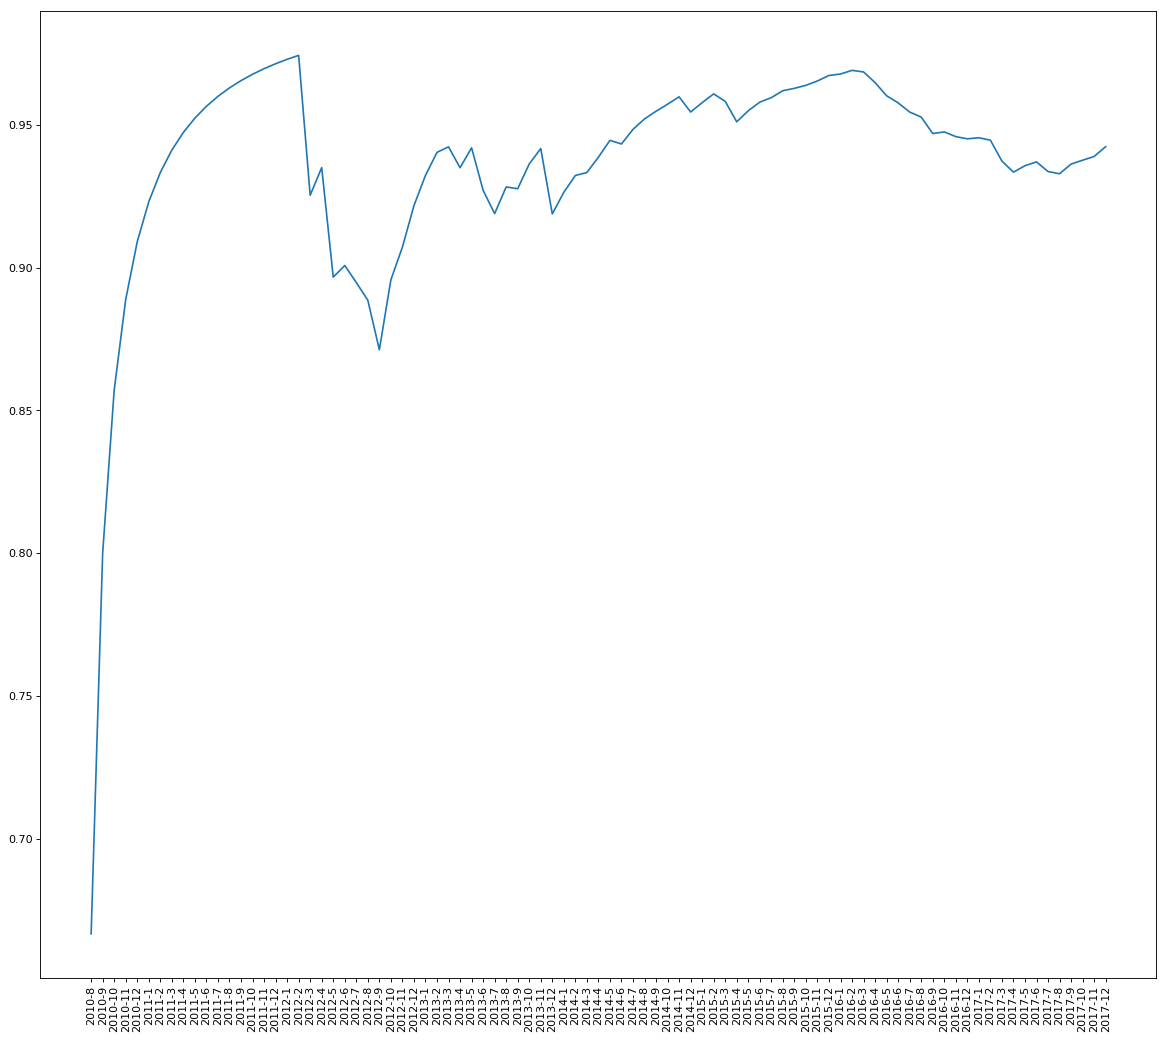

In [28]:
dates = list(co_citation_analysis.keys())[1:]
values = [analysis['similarity_year_before'] for analysis in list(co_citation_analysis.values())[1:]]
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates, values)
plt.xticks(list(dates), [date.split(' to ')[1] for date in dates], rotation='vertical')
plt.show()

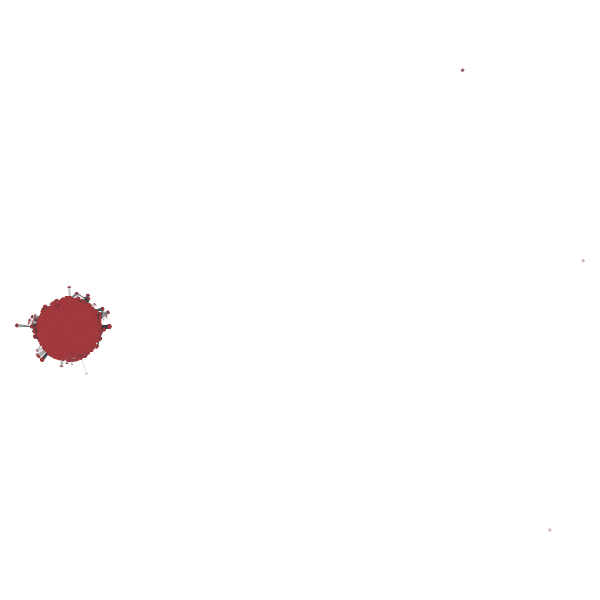

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f0d4c2a6a90, at 0x7f0d35dfc828>

In [30]:
graph_draw(co_citation_networks['2010-1 to 2017-12'])

### Generación Red de Co-aparación de las anotaciones

In [ ]:
cooccurrence_networks = get_co_occurrence_network_incremental('', 'zika', 2010, 2018, output_path=output_path + 'gt/',
                                                              mongo_config=mongo_config, save=True, use_cache=True)

## Análisis de ráfaga

### Ráfaga de palabras utilizando las anotaciones

### Ráfaga de palabras utilizando el texto completo

### Ráfaga de palabras utilizando título y abstract

### Ráfaga de palabras utilizando palabras clave

### Ráfaga de palabras utilizando MESH

## Detección de frentes de investigación

### Análisis del cambio en los autores

### Análisis del cambio en la interdisciplinariedad

### Análisis de ráfaga de palabras